In [50]:
import os
import sys
import time
import copy

import torch
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
from torchvision.datasets import MNIST
from torchvision import transforms

from tqdm.notebook import tqdm

import shutil
import tempfile
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.utilities.cloud_io import load as pl_load
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler, PopulationBasedTraining
from ray.tune.integration.pytorch_lightning import TuneReportCallback, \
    TuneReportCheckpointCallback



# adding relevant files to PATH
sys.path.append("../src/expB/")

from ptcifar.models import ResNet18
from spheres import RandomSphere
from myNNs import *

In [48]:
class ResNet18MfldDistRegressor(pl.LightningModule):
    """
    This has been adapted from
    https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09
    """

    def __init__(self, config, data_dir=None):
        super(ResNet18MfldDistRegressor, self).__init__()

        self.data_dir = data_dir or os.getcwd()
        
        self.lr = config["lr"]
        self.momentum = config["momentum"]
        
        self.batch_size = config["batch_size"]
        self.optimizer_type = config["optimizer_type"]
        self.scheduler_params = config["scheduler_params"]
        
        self.train_epoch_losses = list()
        
        self.num_epochs = config["num_epochs"]
        
        # defining the model
        self.model = ResNet18(num_classes=1)
        
        
    def forward(self, x):
        
        x = self.model(x)
        
        return x



    def mean_squared_error(self, logits, labels):
        return F.mse_loss(logits, labels)


    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.mean_squared_error(logits, y)

#         self.log("ptl/train_loss", loss)
        self.train_epoch_losses.append(loss.item())
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.mean_squared_error(logits, y)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_train_loss = np.mean(self.train_epoch_losses)
        self.log("ptl/val_loss", avg_val_loss)
        self.log("ptl/train_loss", avg_train_loss)
        self.train_epoch_losses = list()

    @staticmethod
    def download_data(data_dir):
        train_set = torch.load(os.path.join(data_dir, "train_cifar_dim.pt"))
        val_set = torch.load(os.path.join(data_dir, "val_cifar_dim.pt"))
        return train_set, val_set

    def prepare_data(self):
        self.train_set, self.val_set = self.download_data(self.data_dir)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=int(self.batch_size))

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=int(self.batch_size))

    def configure_optimizers(self):
        optimizer = None
        if self.optimizer_type == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.optimizer_type == "sgd":
            optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=self.momentum)
        
        lr_sched_factor = lambda epoch: epoch / (self.scheduler_params["warmup"]) if epoch <= self.scheduler_params["warmup"] else (1 if epoch > self.scheduler_params["warmup"] and epoch < self.scheduler_params["cooldown"] else max(0, 1 + (1 / (self.scheduler_params["cooldown"] - self.num_epochs)) * (epoch - self.scheduler_params["cooldown"])))
        
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_sched_factor)
        
        return [optimizer], [scheduler]


def train_mnist(config, data_dir, num_epochs):
    model = ResNet18MfldDistRegressor(config, data_dir)
    trainer = pl.Trainer(max_epochs=num_epochs, gpus=1)

    trainer.fit(model)

In [ ]:
def train_model_tune_checkpoint(config,
                                checkpoint_dir=None,
                                data_dir=None,
                                num_epochs=10,
                                num_gpus=1):
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        gpus=num_gpus,
        logger=TensorBoardLogger(
            save_dir=tune.get_trial_dir(), name="", version="."),
        callbacks=[
            TuneReportCheckpointCallback(
                metrics={
                    "val_loss": "ptl/val_loss"
                },
                filename="checkpoint",
                on="validation_end"),
            LearningRateMonitor(logging_interval='epoch', log_momentum=True)
        ])
    if checkpoint_dir:
        # Currently, this leads to errors:
        # model = LightningMNISTClassifier.load_from_checkpoint(
        #     os.path.join(checkpoint, "checkpoint"))
        # Workaround:
        ckpt = pl_load(
            os.path.join(checkpoint_dir, "checkpoint"),
            map_location=lambda storage, loc: storage)
        model = ResNet18MfldDistRegressor._load_model_state(
            ckpt, config=config, data_dir=data_dir)
        trainer.current_epoch = ckpt["epoch"]
    else:
        model = ResNet18MfldDistRegressor(config=config, data_dir=data_dir)

    trainer.fit(model)

In [ ]:
def tune_model(data_dir, num_samples=1, num_epochs=500, gpus_per_trial=1):
    
    
    ResNet18MfldDistRegressor.download_data(data_dir)

    config = {
        "lr": tune.grid_search([1e-2, 1e-3, 1e-5, 1e-6]),
        "batch_size": tune.grid_search([128, 256, 512]),
        "optimizer_type": tune.grid_search(["adam", "sgd"]),
        "momentum": tune.grid_search([0.9, 0.5, 0.2]),
        "scheduler_params": {"warmup": 10, "cooldown": 300}
    }


    reporter = CLIReporter(
        parameter_columns=["lr", "momentum", "batch_size", "optimizer_type"],
        metric_columns=["loss", "training_iteration"])

    analysis = tune.run(
        tune.with_parameters(
            train_model_tune_checkpoint,
            data_dir=data_dir,
            num_epochs=num_epochs,
            num_gpus=gpus_per_trial),
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        progress_reporter=reporter,
        name="tune_dist_learn_resnet18")

    print("Best hyperparameters found were: ", analysis.best_config)


In [49]:
NUM_EPOCHS = 500
DATA_DIR = "../datasets/expB/"

config = {
    
    "lr": 1e-3,
    "momentum": 0.9,
    "batch_size": 512,
    "optimizer_type": "sgd",
    "scheduler_params": {"warmup": 10, "cooldown": 300},
    "num_epochs": NUM_EPOCHS
    
}

train_mnist(config, DATA_DIR, NUM_EPOCHS)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.677    Total estimated model params size (MB)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


In [25]:
lr_sched_factor = lambda epoch: epoch / (100) if epoch <= 100 else (1 if epoch > 100 and epoch < 300 else max(0, 1 + (1 / (300 - 500)) * (epoch - 300)))



In [26]:
test = []
initial_lr = 1e-3
for i in range(500):
    test.append(lr_sched_factor(i) * initial_lr)

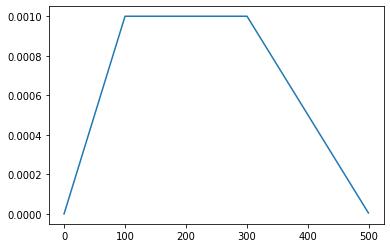

In [27]:
plt.plot(test)